In [1]:
# Importar librerías
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2
import imageio.v2 as imageio

In [2]:
# Crear función para crear una figura, un gif y un video con dos gráficos
def func(csv1, csv2):
    df1 = pd.read_csv(csv1, header=None, dtype=np.float32)
    df2 = pd.read_csv(csv2, index_col=0, dtype={'state': str, 'RMSD': np.float32})

    x1, y1 = df1.iloc[:, 0].to_numpy(), df1.iloc[:, 1].to_numpy()
    size = [(i * 0.05) + 1 for i in range(x1.shape[0])]
    x2, y2 = df2.iloc[:, 0].to_numpy(), df2.iloc[:, 1].to_numpy()

    dfv = df2.state.values
    col = np.empty(len(dfv), dtype=object)
    raw = df2['RMSD'].to_numpy()
    amin, amax = raw.min(), raw.max()
    raw = (raw - amin) / (amax - amin)

    col[dfv == "active"] = '#7E2F8E'
    col[dfv == "inactive"] = '#EDB120'
    col[dfv == "transition"] = '#D95319'

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Active', markerfacecolor='#7E2F8E', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Inactive', markerfacecolor='#EDB120', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Transition', markerfacecolor='#D95319', markersize=8)
    ]

    legend_elements2 = [
        Line2D([0], [0], color='#7E2F8E', label='Active', markersize=8),
        Line2D([0], [0], color='#EDB120', label='Inactive', markersize=8),
        Line2D([0], [0], color='#D95319', label='Transition', markersize=8)
    ]

    # Crear figura, subplots y configuración
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [4, 2]})
    fig.suptitle('11097_3Dx_umap', fontweight='heavy', fontsize=20, x=0.5) # name
    fig.tight_layout(pad=2, h_pad=4)

    # Primer gráfico
    axs[0].scatter(x1, y1, color=col, s=size, alpha=raw, edgecolors='black', linewidth=0.3)
    axs[0].set_aspect('equal')
    longest_axis = max(max(x1) - min(x1), max(y2) - min(y2))
    if longest_axis is x1:
        axs[0].set_ylim(axs[0].get_xlim())
    else:
        axs[0].set_xlim(axs[0].get_ylim())
    axs[0].grid(color='grey', alpha=0.2)
    axs[0].legend(handles=legend_elements, loc='best')
    axs[0].set_title('Posiciones X e Y para cada amonoácido', fontweight='heavy', loc='center')
    axs[0].set_xlabel('Eje X')
    axs[0].set_ylabel('Eje Y')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Segundo gráfico
    state_colors = {'active': '#7E2F8E', 'inactive': '#EDB120', 'transition': '#D95319'}
    for (xi, yi), (xf, yf), state in zip(zip(x2, y2), zip(x2[1:], y2[1:]), df2['state']):
        axs[1].plot([xi, xf], [yi, yf], color=state_colors[state])
        axs[1].fill_between([xi, xf], [yi, yf], color=state_colors[state], alpha=0.04)
    axs[1].grid(color='grey', alpha=0.2)
    axs[1].legend(handles=legend_elements2, loc='best')
    axs[1].set_title('Distancias', fontweight='heavy', loc='center')
    axs[1].set_xlabel('Tiempo (frames)')
    axs[1].set_ylabel('RMSD')

    # Guardar figura estática
    plt.savefig('./prueba/graph.png', transparent=False, facecolor='white')
    plt.show()
    
    # Crear carpeta para guardar las imágenes para el video
    folder = './prueba/imgs/'
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        print("Carpeta creada exitosamente.")
    else:
        print("La carpeta ya existe.")
        
    def generar_imgs():
        # Graficar dinámicamente los datos
        def graf_din(n, num_points):
            fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [4, 2]})
            fig.suptitle('11097_3Dx_umap', fontweight='heavy', fontsize=20, x=0.5) # name
            fig.tight_layout(pad=2, h_pad=4)

            axs[0].scatter(x1[:num_points], y1[:num_points], color=col[:num_points], s=size[:num_points],
                           alpha=raw[:num_points], edgecolors='black', linewidth=0.3)
            axs[0].set_aspect('equal')
            longest_axis = max(max(x1) - min(x1), max(y2) - min(y2))
            if longest_axis is x1:
                axs[0].set_ylim(axs[0].get_xlim())
            else:
                axs[0].set_xlim(axs[0].get_ylim())
            axs[0].grid(color='grey', alpha=0.2)
            axs[0].legend(handles=legend_elements, loc='best')
            axs[0].set_title('Posiciones X e Y para cada amonoácido', fontweight='heavy', loc='center')
            axs[0].set_xlabel('Eje X')
            axs[0].set_ylabel('Eje Y')
            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)

            for (xi, yi), (xf, yf), state in zip(zip(x2[:num_points], y2[:num_points]),
                                                 zip(x2[1:num_points + 1], y2[1:num_points + 1]),
                                                 df2['state'][:num_points]):
                axs[1].plot([xi, xf], [yi, yf], color=state_colors[state])
                axs[1].fill_between([xi, xf], [yi, yf], color=state_colors[state], alpha=0.04)
            axs[1].grid(color='grey', alpha=0.2)
            axs[1].legend(handles=legend_elements2, loc='best')
            axs[1].set_title('Distancias', fontweight='heavy', loc='center')
            axs[1].set_xlabel('Tiempo (frames)')
            axs[1].set_ylabel('RMSD')
            
            plt.savefig(folder + f'imagen_{n}.png', transparent=False, facecolor='white')
            plt.close()

        num_points = 50
        for i in range(num_points, len(x1) + 1, num_points):
            graf_din(i, i)

    generar_imgs()

    # Crear video y gif
    images = sorted([img for img in os.listdir(folder) if img.endswith(".png")], key=lambda x: int(x.split("_")[1].split(".")[0]))

    frame = cv2.imread(os.path.join(folder, images[0]))
    height, width, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    video = cv2.VideoWriter('./prueba/video.mp4', fourcc, 6, (width, height))
    frames = []
    for image in images:
        image_path = os.path.join(folder, image)
        frame = cv2.imread(image_path)
        video.write(frame)
        frames.append(imageio.imread(image_path))

    cv2.destroyAllWindows()
    video.release()

    imageio.mimsave('./prueba/gif.gif', frames, 'GIF', loop=0)

    # Eliminar las imágenes luego de crear el video y el gif
    shutil.rmtree(folder)


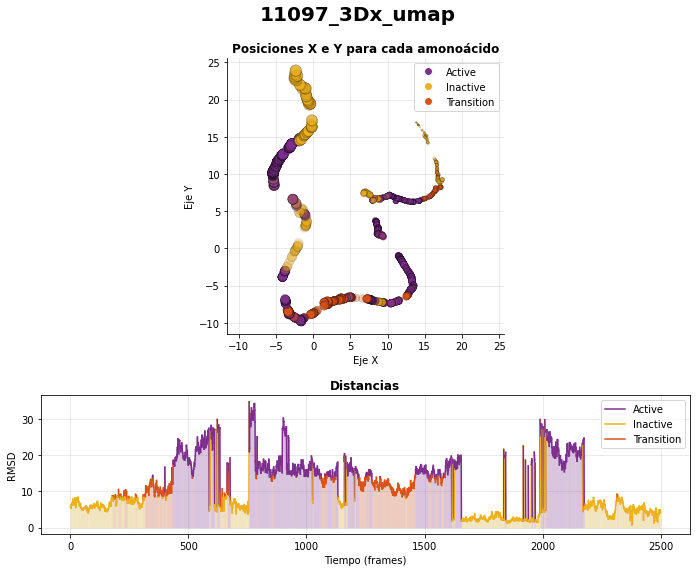

Carpeta creada exitosamente.


In [3]:
# Llamar a la función
func('./prueba/11097_3Dx_umap.csv', './prueba/11097.csv')